# Netflix recommendations

<div class="alert alert-block alert-warning">
Replace <code>YOUR_GITHUB_TOKEN</code> in the install script. To get your token follow the instructions in the <a href="../README.md">README.md</a>
</div>

## Boilerplate

### Installation

In [1]:
%pip install  'https://us-central1-data-359211.cloudfunctions.net/github-proxy/superlinked-2.21.0-py3-none-any.whl?token=YOUR_GITHUB_TOKEN'

### Imports and constants

In [2]:
from datetime import timedelta, datetime

import altair as alt
import pandas as pd

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import String, Timestamp
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import InMemoryExecutor, InMemoryApp
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.query.result import Result
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.recency_space import RecencySpace

alt.renderers.enable('mimetype')
pd.set_option('display.max_colwidth', 200)

In [3]:
MODEL = "sentence-transformers/paraphrase-MiniLM-L3-v2"
YEAR_IN_DAYS = 365
TOP_N = 10
DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-netflix-shows-dataset/titles.csv"

## Prepare dataset

In [4]:
movie_df = pd.read_csv(DATASET_URL)
movie_df = movie_df[["description", "genres", "title", "release_year", "id"]].drop_duplicates(subset=["description"]).dropna(how='any')
movie_df["genres"] = movie_df["genres"].apply(lambda x: " ".join(eval(x)))
movie_df["timestamp"] = [pd.Timestamp(year=year, month=1, day=1).timestamp() for year in movie_df["release_year"].tolist()]
movie_df.head()

,description,genres,title,release_year,id,timestamp
0,"This collection includes 12 World War II-era propaganda films — many of which are graphic and offensive — discussed in the docuseries ""Five Came Back.""",documentation,Five Came Back: The Reference Films,1945,ts300399,-788918400.0
1,A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.,drama crime,Taxi Driver,1976,tm84618,189302400.0
2,"Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous Ameri...",drama action thriller european,Deliverance,1972,tm154986,63072000.0
3,"King Arthur, accompanied by his squire, recruits his Knights of the Round Table, including Sir Bedevere the Wise, Sir Lancelot the Brave, Sir Robin the Not-Quite-So-Brave-As-Sir-Lancelot and Sir G...",fantasy action comedy,Monty Python and the Holy Grail,1975,tm127384,157766400.0
4,"12 American military prisoners in World War II are ordered to infiltrate a well-guarded enemy château and kill the Nazi officers vacationing there. The soldiers, most of whom are facing death sent...",war action,The Dirty Dozen,1967,tm120801,-94694400.0


## Set up Superlinked

In [5]:
@schema
class MovieSchema:
    description: String
    title: String
    release_timestamp: Timestamp
    genres: String
    id: IdField

In [6]:
movie = MovieSchema()

In [7]:
description_space = TextSimilaritySpace(text=movie.description, model=MODEL)
title_space = TextSimilaritySpace(text=movie.title, model=MODEL)
genre_space = TextSimilaritySpace(text=movie.genres, model=MODEL)
recency_space = RecencySpace(timestamp=movie.release_timestamp, period_time_list=[
    PeriodTime(timedelta(days=4 * YEAR_IN_DAYS)), 
    PeriodTime(timedelta(days=10 * YEAR_IN_DAYS)), 
    PeriodTime(timedelta(days=40 * YEAR_IN_DAYS))],
    negative_filter=-0.25)

In [8]:
movie_index = Index(spaces=[description_space, title_space, genre_space, recency_space])

In [9]:
query_text_param = Param("query_text")

simple_query = (
    Query(movie_index, weights={
        description_space: Param("description_weight"),
        title_space: Param("title_weight"),
        genre_space: Param("genre_weight"),
        recency_space: Param("recency_weight")
    })
    .find(movie)
    .similar(description_space.text, query_text_param)
    .similar(title_space.text, query_text_param)
    .similar(genre_space.text, query_text_param)
    .limit(TOP_N)
)

advanced_query = (
    Query(movie_index, weights={
        description_space: Param("description_weight"),
        title_space: Param("title_weight"),
        genre_space: Param("genre_weight"),
        recency_space: Param("recency_weight")
    })
    .find(movie)
    .similar(description_space.text, Param("description_query_text"))
    .similar(title_space.text, Param("title_query_text"))
    .similar(genre_space.text, Param("genre_query_text"))
    .limit(TOP_N)
)

In [10]:
df_parser = DataFrameParser(schema=movie, mapping={movie.release_timestamp: "timestamp"})

In [11]:
source: InMemorySource = InMemorySource(movie, parser=df_parser)
executor: InMemoryExecutor = InMemoryExecutor(sources=[source], indices=[movie_index])
app: InMemoryApp = executor.run()

This next one might take several minutes to run. Getting a coffee or water, or doing a quick planking workout is advised.

In [12]:
source.put([movie_df])

## Understanding recency

Recency can seem quite complex at first, let's see how the score looks like for the relevant time periods

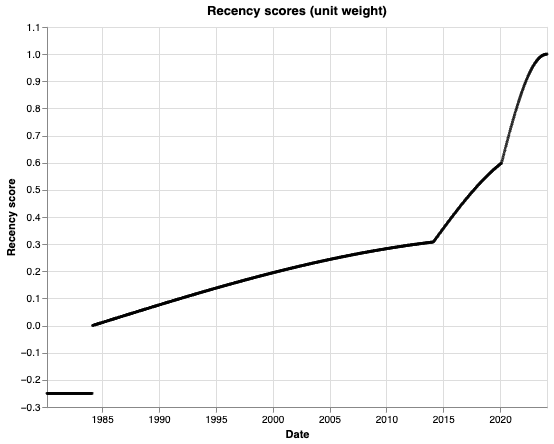

In [13]:
recency_plotter = RecencyPlotter(recency_space)
chart = recency_plotter.plot_recency_curve()
chart

notice the breaks in the score at 4, 10 and 40 years - those are our period times. Titles older than 40 years get `negative_filter` score.

## Run queries

Let's define a quick util function to present our results in the notebook

In [14]:
def present_result(result: Result, cols_to_keep: list[str] = ["description", "title", "genres", "release_year", "id"]) -> pd.DataFrame:
    # parse result to dataframe
    df: pd.DataFrame = pd.DataFrame([entry.stored_object for entry in result.entries])
    # transform timestamp back to release year
    df["release_year"] = [datetime.fromtimestamp(timestamp).year for timestamp in df["release_timestamp"]]
    return df[cols_to_keep]

### Search with user queries

With the simple query, I can search with my text in all of the fields

In [15]:
result: Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0
)

present_result(result)

,description,title,genres,release_year,id
0,"When a group of people meets at the same party, they form four different relationships, each experiencing similar phases of love.","Love, Surreal and Odd",comedy romance,2017,tm313118
1,"'Love Actually' follows the lives of eight very different couples dealing with their love lives, in various loosely and interrelated tales, all set during a frantic month before Christmas in Londo...",Love Actually,drama comedy romance,2003,tm133767
2,"A young woman develops romantic feelings for her best friend, but problems arise when another gal enters the picture.",Must Be... Love,comedy romance,2013,tm188290
3,Romantic anthology web series revolving around 12 stories of 12 months of young people on their paths to love.,Love Daily,drama romance,2018,ts90869
4,"Love You, is a 2011 Taiwanese drama starring Joseph Chang, Rainie Yang, Kingone Wang, Tiffany Hsu, Alien Huang and Tom Price. It is the second installment of the Fated to Love You trilogy. It star...",Drunken to Love You,comedy drama romance,2011,ts44064
5,Laida Magtalas is a modern-day Belle who works hard to provide for her family while hoping that someday she will meet her prince charming and that they will live happily ever after together. That ...,A Very Special Love,comedy drama romance,2008,tm28024
6,"It tells the love story of two childhood sweethearts that spans 19 years. Chen Xiao Xi is a cute and small girl with a lot of positive energy. She gets to know Jiang Chen, a tall and proud genius ...",A Love So Beautiful,comedy romance,2017,ts77034
7,"Christina's love life is stuck in neutral. After years of avoiding the hazards of a meaningful relationship, one night while club-hopping with her girlfriends, she meets Peter, her perfect match. ...",The Sweetest Thing,comedy romance,2002,tm111600
8,"Mike Birbiglia shares a lifetime of romantic blunders and misunderstandings. On this painfully honest but hilarious journey, Birbiglia struggles to find reason in an area where it may be impossibl...",Mike Birbiglia: My Girlfriend's Boyfriend,comedy documentation romance,2013,tm171965
9,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted romantic comedy...",Love Hard,romance comedy,2021,tm1093099


After looking at the results, I see some titles I have already seen. I can bias towards recent titles by upweighting recency. Weights are normalised to have unit sum, so you don't have to worry about how you set them.

In [16]:
result: Result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=3
)

present_result(result)

,description,title,genres,release_year,id
0,"In this romantic comedy, several friends, each dealing with unhappy love lives, turn to each other for help - but not always with the best results.",F*ck Love Too,comedy romance,2022,tm1203307
1,"Fidelity tells a story of marital fidelity, in particular the one of Carlo and Margherita, a young couple who needs to face the deflagrant consequences of an alleged betrayal. Their relationship b...","Devotion, a Story of Love and Desire",drama romance,2022,ts280892
2,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
3,"A relatable romance drama about a couple in their 30s preparing for marriage. While they were expecting a happy ending like something out of a fairy tale, the reality of their preparations proves ...",Welcome to Wedding Hell,drama romance,2022,ts344043
4,"An ad executive and a fashion designer-blogger don't believe in love, so they place a bet to make the other fall head over heels - with unusual tactics.",Love Tactics,comedy romance,2022,tm1152224
5,"Often (mis)guided by a cheeky imaginary wizard, an awkward and lonely 20-something struggles to get out of his own way in his quest for a girlfriend.",Eternally Confused and Eager for Love,comedy romance,2022,ts330012
6,"Guille decides it's time to take the next step and that's how she looks to marry her sweetheart, but things get complicated and nothing goes as planned.","Let's Tie the Knot, Honey!",comedy romance,2022,tm1204412
7,"A modern love story set in the near future where an AI building is powered by human feelings. Due to a software glitch, it falls in love with a real girl, escapes the building into the body of a r...",AI Love You,scifi comedy romance drama,2022,tm1160424
8,"After his ad agency goes bankrupt, an indebted Fırat falls for a singer at a yoga retreat and joins her on a journey of self-realization.",Doom of Love,romance drama,2022,tm1218702
9,A wife who feels suffocated by her husband's incessant attention hires a psychologist to make him fall in love with her so that she can separate from him.,Hey! Sinamika,drama romance,2022,tm1143258


Still using the simple query, I can give more weight to spaces if I think my query is more related to that space - matches there should count more. Here I give additional weight to the genre, leave the description as is, and downweight the title as my query text is mostly a genre with some additional context. I keep recency with unit weight too, as I would like my results to be a bit biased towards recent movies.

In [17]:
result = app.query(
    simple_query,
    query_text="Heartfelt romantic comedy",
    description_weight=1,
    title_weight=0.1,
    genre_weight=2,
    recency_weight=1
)

present_result(result)

,description,title,genres,release_year,id
0,"In this romantic comedy, several friends, each dealing with unhappy love lives, turn to each other for help - but not always with the best results.",F*ck Love Too,comedy romance,2022,tm1203307
1,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted romantic comedy...",Love Hard,romance comedy,2021,tm1093099
2,"A relatable romance drama about a couple in their 30s preparing for marriage. While they were expecting a happy ending like something out of a fairy tale, the reality of their preparations proves ...",Welcome to Wedding Hell,drama romance,2022,ts344043
3,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
4,"In this rom-com challenging the concept of soulmates, parallel storylines portray four single friends as they pair up in different couple combinations.",Four to Dinner,comedy romance,2022,tm1137862
5,Todd and Rory are intellectual soul mates. He might be gay. She might not care. A romantic-comedy drama with a twist; a love story without the thrill of copulation.,Straight Up,comedy romance,2019,tm494295
6,Short films follow young adults as they navigate the gamut of emotions that come with finding romantic connection in unexpected places.,Feels Like Ishq,drama romance comedy,2021,ts283610
7,"Guille decides it's time to take the next step and that's how she looks to marry her sweetheart, but things get complicated and nothing goes as planned.","Let's Tie the Knot, Honey!",comedy romance,2022,tm1204412
8,Incurable romantic Lotte's life is upended when her plans for a picture-perfect wedding unravel--just as her self-absorbed sister gets engaged.,Just Say Yes,comedy romance,2021,tm904862
9,"In pursuit of both success and validation, a group of tech-savvy individuals juggle intimate encounters, first impressions and romantic opportunities.",Slay,romance comedy,2021,tm1038025


With the advanced query, I can even supply different search terms for each attribute of the movie.

In [18]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=1,
    title_weight=1,
    genre_weight=1,
    recency_weight=0
)

present_result(result)

,description,title,genres,release_year,id
0,"'Love Actually' follows the lives of eight very different couples dealing with their love lives, in various loosely and interrelated tales, all set during a frantic month before Christmas in Londo...",Love Actually,drama comedy romance,2003,tm133767
1,Rebellious Mickey and good-natured Gus navigate the thrills and agonies of modern relationships.,Love,comedy drama romance,2016,ts38511
2,A rising black painter tries to break into a competitive art world while balancing an unexpected romance with an ambitious law student.,Really Love,romance drama,2020,tm946360
3,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted romantic comedy...",Love Hard,romance comedy,2021,tm1093099
4,Romantic anthology web series revolving around 12 stories of 12 months of young people on their paths to love.,Love Daily,drama romance,2018,ts90869
5,"Adam and Marklin’s 5-year relationship has gone from a passionate flame to a simmer, forcing them to reconcile with each other’s shortcomings while their friends endlessly search for love in New Y...",Almost Love,comedy drama romance,2019,tm472195
6,Laida Magtalas is a modern-day Belle who works hard to provide for her family while hoping that someday she will meet her prince charming and that they will live happily ever after together. That ...,A Very Special Love,comedy drama romance,2008,tm28024
7,"Two young kids fall in love with each other. But the passion is too consuming for the parents of Jade. The parents try to stop them from seeing each other. But when this doesn't work, David burns ...",Endless Love,romance drama,1981,tm130586
8,"Love is as tough as it is sweet for a lovestruck teenager, whose relationship with her next-door neighbor transforms as they grow into adulthood.",A Love So Beautiful,comedy drama,2020,ts357033
9,"A young woman develops romantic feelings for her best friend, but problems arise when another gal enters the picture.",Must Be... Love,comedy romance,2013,tm188290


And even give different weights to each subsearch if I really do care that the title is related to love but I am not really emotionally attached to my description of the movie I would want to see.

In [19]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=0
)

present_result(result)

,description,title,genres,release_year,id
0,Rebellious Mickey and good-natured Gus navigate the thrills and agonies of modern relationships.,Love,comedy drama romance,2016,ts38511
1,"'Love Actually' follows the lives of eight very different couples dealing with their love lives, in various loosely and interrelated tales, all set during a frantic month before Christmas in Londo...",Love Actually,drama comedy romance,2003,tm133767
2,The story of a family and the various situations navigated by a husband and wife.,Love,thriller drama,2020,tm946277
3,A rising black painter tries to break into a competitive art world while balancing an unexpected romance with an ambitious law student.,Really Love,romance drama,2020,tm946360
4,"Adam and Marklin’s 5-year relationship has gone from a passionate flame to a simmer, forcing them to reconcile with each other’s shortcomings while their friends endlessly search for love in New Y...",Almost Love,comedy drama romance,2019,tm472195
5,"Two young kids fall in love with each other. But the passion is too consuming for the parents of Jade. The parents try to stop them from seeing each other. But when this doesn't work, David burns ...",Endless Love,romance drama,1981,tm130586
6,"The story of Richard and Mildred Loving, an interracial couple, whose challenge of their anti-miscegenation arrest for their marriage in Virginia led to a legal battle that would end at the US Sup...",Loving,drama romance,2016,tm219233
7,Laida Magtalas is a modern-day Belle who works hard to provide for her family while hoping that someday she will meet her prince charming and that they will live happily ever after together. That ...,A Very Special Love,comedy drama romance,2008,tm28024
8,"Love, Now is a 72 episode Taiwanese idol romance drama television series created and developed by SETTV. It stars Annie Chen, George Hu as the main leads and Bobby Dou, Harry Chang from Taiwanese ...","Love, Now",drama,2012,ts69208
9,"Ian Montes is a picture of success. Despite being a son of a shipping tycoon, Ian refused to just ride in his father's empire. He built his own real estate company and earned his first million at ...",A Love Story,drama romance,2007,tm76399


Then I can bias again towards recent movies

In [20]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=5
)

present_result(result)

,description,title,genres,release_year,id
0,"After his ad agency goes bankrupt, an indebted Fırat falls for a singer at a yoga retreat and joins her on a journey of self-realization.",Doom of Love,romance drama,2022,tm1218702
1,"An ad executive and a fashion designer-blogger don't believe in love, so they place a bet to make the other fall head over heels - with unusual tactics.",Love Tactics,comedy romance,2022,tm1152224
2,"Fidelity tells a story of marital fidelity, in particular the one of Carlo and Margherita, a young couple who needs to face the deflagrant consequences of an alleged betrayal. Their relationship b...","Devotion, a Story of Love and Desire",drama romance,2022,ts280892
3,This black humor pan-Arabic anthology series is about love in general – and relationships in particular.,"Love, Life & Everything in Between",comedy drama romance,2022,ts329711
4,"A modern love story set in the near future where an AI building is powered by human feelings. Due to a software glitch, it falls in love with a real girl, escapes the building into the body of a r...",AI Love You,scifi comedy romance drama,2022,tm1160424
5,"Often (mis)guided by a cheeky imaginary wizard, an awkward and lonely 20-something struggles to get out of his own way in his quest for a girlfriend.",Eternally Confused and Eager for Love,comedy romance,2022,ts330012
6,"An LA girl, unlucky in love, falls for an East Coast guy on a dating app and decides to surprise him for the holidays, only to discover that she's been catfished. This lighthearted romantic comedy...",Love Hard,romance comedy,2021,tm1093099
7,The story of a family and the various situations navigated by a husband and wife.,Love,thriller drama,2020,tm946277
8,"Haruto Asakura falls in love with hairdresser Misaki Ariake and asks her out. Watching Misaki Ariake work hard to achieve what she wants, Haruto Asakura, who almost gave up his dream to become a p...",Love Like the Falling Petals,drama romance,2022,tm1119015
9,"Inside a national weather service, love proves just as difficult to predict as rain or shine for a diligent forecaster and her free-spirited co-worker.",Forecasting Love and Weather,drama romance,2022,ts319412


Or maybe to older ones

In [21]:
result = app.query(
    advanced_query,
    description_query_text="Heartfelt lovely romantic comedy for a cold autumn evening.",
    title_query_text="love",
    genre_query_text="drama comedy romantic",
    description_weight=0.2,
    title_weight=3,
    genre_weight=1,
    recency_weight=-10
)

present_result(result)

,description,title,genres,release_year,id
0,"Two young kids fall in love with each other. But the passion is too consuming for the parents of Jade. The parents try to stop them from seeing each other. But when this doesn't work, David burns ...",Endless Love,romance drama,1981,tm130586
1,"Anil, a street singer, is humiliated and driven out of Bombay along with his mother. However, he soon becomes a famous performer but the enemies from his past try to destroy his hard-earned career.",Disco Dancer,drama romance,1982,tm52815
2,"An honest man dreams of a better life for his family, but a childhood friend leads him into a world of crime that keeps happiness just out of reach.",Ujala,romance crime drama,1959,tm358653
3,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes sisters w...,White Christmas,romance comedy,1954,tm16479
4,"Brian Cohen is an average young Jewish man, but through a series of ridiculous events, he gains a reputation as the Messiah. When he's not dodging his followers or being scolded by his shrill moth...",Life of Brian,comedy,1979,tm70993
5,"Geeky student Arnie Cunningham falls for Christine, a rusty 1958 Plymouth Fury, and becomes obsessed with restoring the classic automobile to her former glory. As the car changes, so does Arnie, w...",Christine,horror thriller european,1983,tm54450
6,"Maharaj Brajbhan lives a wealthy lifestyle in Bharatpur, India along with his wife, Badi Rani, but have been unable to conceive for Bharatpur, and have no choice but to leave it's reigns with Braj...",Bandie,drama action romance,1978,tm16812
7,"Shahjada Ijjat Beg comes to India with his caravan and settles in a town in Gujrat. Here he falls in love with Sohani, who keeps a shop in metal pots. Ijjat Beg buys pot from her with whatever mon...",Sohni Mahiwal,romance drama action,1984,tm172482
8,"Two small children and a ship's cook survive a shipwreck and find safety on an idyllic tropical island. Soon, however, the cook dies and the young boy and girl are left on their own. Days become y...",The Blue Lagoon,romance action drama,1980,tm98978
9,"In the 1930s, bored waitress Bonnie Parker falls in love with an ex-con named Clyde Barrow and together they start a violent crime spree through the country, stealing cars and robbing banks.",Bonnie and Clyde,crime drama action,1967,tm119281


notice that every movie before 1984 has the same recency score as our largest period time is 40 years.

### Search with a movie and queries

Now I found a movie in the last result set that I have already seen but I would love something similar. White Christmas (1954) is a story about people forming a rock-band and of course there is some love along the way. It has the id "tm16479".

I can query my dataset using this movie, too! Let's adjust the defined query first:

In [22]:
with_movie_query = advanced_query.with_vector(movie, Param("movie_id"))

with this modification, I can add a movie from the dataset to the search.

Let's first just focus on movies with similar descriptions. The first result will of course be the movie we are searching with.

In [23]:
result = app.query(
    with_movie_query,
    description_query_text="",
    title_query_text="",
    genre_query_text="",
    description_weight=1,
    title_weight=0,
    genre_weight=0,
    recency_weight=0,
    movie_id="tm16479"
)

present_result(result)

,description,title,genres,release_year,id
0,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes sisters w...,White Christmas,romance comedy,1954,tm16479
1,"Aditya, Joe, Kedar and Rob form a rock band, but break up after they fail to make a success of it. They establish regular lives until they decide to reunite and take another shot at fulfilling the...",Rock On!!,drama music,2008,tm37945
2,"Go backstage with French rap duo Bigflo & Oli in this intimate music documentary, then join the superstar siblings as they embark on a major tour.",Bigflo & Oli: Hip Hop Frenzy,documentation music,2020,tm937044
3,"A dream of the hope for intimacy and love in a brutal, divisive world.",Condom Lead,drama,2013,tm1036195
4,A duo of street performers learns how sound and picture work together to create amazing cinema experiences.,Silent,animation family action,2014,tm137379
5,"Childhood friends Suresh and Vinnie want to become successful dancers. To fulfill their dreams, they form a dance group with their friends and compete in a hip-hop contest in Las Vegas.",ABCD 2,music drama,2015,tm207668
6,"This documentary spotlights Debbie Allen's career and follows her group of dance students as they prepare for Allen's annual ""Hot Chocolate Nutcracker,"" a reimagining of the classic ballet.",Dance Dreams: Hot Chocolate Nutcracker,documentation family,2020,tm946927
7,Follow the lives of an elite group of young dancers who train at The Next Step Studio.,The Next Step,drama family romance,2013,ts35282
8,"Sing along and dance with Bailey, Franny, Kip, Lulu and Tilly in this collection of music videos that will get you in the mood to move and groove!",Word Party Songs,animation family,2020,ts251607
9,Nine struggling musicians share the spotlight in this deeply personal reality series about the challenges and thrills of staging a Hollywood showcase.,Westside,reality,2018,ts84644


I got back movies that focus more on the rock-band aspect of the movie. With query parameters I can try to skew the results to be more related to family.

In [24]:
result = app.query(
    with_movie_query,
    description_query_text="family",
    title_query_text="",
    genre_query_text="",
    description_weight=1,
    title_weight=0,
    genre_weight=0,
    recency_weight=0,
    description_query_weight=1,
    movie_id="tm16479"
)

present_result(result)

,description,title,genres,release_year,id
0,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes sisters w...,White Christmas,romance comedy,1954,tm16479
1,Romantic comedy following four couples who meet through a dating website. Four men go on a heroic mission to help four women and wind up experiencing a series of mishaps.,"All's Well, Ends Well",romance comedy,2012,tm37573
2,An estranged family gathers together in New York for an event celebrating the artistic work of their father.,The Meyerowitz Stories (New and Selected),comedy drama,2017,tm244206
3,"Years after his father disowns his adopted brother for marrying a woman of lower social standing, a young man goes on a mission to reunite his family.",Kabhi Khushi Kabhie Gham,drama romance,2001,tm36475
4,"Reunited in their hometown for their father's funeral, two self-interested brothers meet a peculiar woman who shares a huge secret about their family.",The Bros,comedy fantasy,2017,tm357708
5,"A new couple, their exes and their children navigate the emotional challenges and tricky logistics of blended family life in this Swedish dramedy.",Bonus Family,drama comedy reality family documentation music european,2017,ts55939
6,Three prosperous women -- including a mother and her daughter -- fall for a seductive man in Colombia's Coffee Triangle.,Playing with Fire,drama,2019,ts87680
7,A young couple dream of growing old together as they deal with the struggles of being in a long-term relationship.,The Hows of Us,drama romance comedy,2018,tm430059
8,A dramatic story about a girl and her giving father.,Sen Benim HerŞeyimsin,comedy,2016,tm311456
9,"The loves, heartbreak, jealousy and pain of the three Armoza sisters – Luna, Rachelika, and Becky - their parents, grandparents and children, set during the early-mid 20th century in Jerusalem.",The Beauty Queen of Jerusalem,drama,2021,ts252119


Taking a closer look at the description of these result movies, we can see that they share some aspect of the movie we are searching with - blended together with some notion of family:

After all, this evening I am in the mood for something light - I can also skew the results towards a specific genre: comedy

In [26]:
result = app.query(
    with_movie_query,
    description_query_text="",
    title_query_text="",
    genre_query_text="comedy",
    description_weight=1,
    title_weight=0,
    genre_weight=2,
    recency_weight=0,
    description_query_weight=1,
    movie_id="tm16479"
)

present_result(result)

,description,title,genres,release_year,id
0,Two talented song-and-dance men team up after the war to become one of the hottest acts in show business. In time they befriend and become romantically involved with the beautiful Haynes sisters w...,White Christmas,romance comedy,1954,tm16479
1,Romantic comedy following four couples who meet through a dating website. Four men go on a heroic mission to help four women and wind up experiencing a series of mishaps.,"All's Well, Ends Well",romance comedy,2012,tm37573
2,"On a bet, a gridiron hero at John Hughes High School sets out to turn a bespectacled plain Jane into a beautiful and popular prom queen in this outrageous send-up of the teen movies of the 1980s a...",Not Another Teen Movie,comedy,2001,tm58382
3,"An original twist on an eternal triangle, where secret crush and unrequited love take on altogether newfangled meanings of their own.",Don't Go Breaking My Heart,romance comedy,2011,tm176128
4,Get ready to scream with laughter! Sam Kinison's primal scream will echo down through the comedy hall of fame summing up so much of modernity's horror and stupidity. This concert was taped at the ...,Sam Kinison: Family Entertainment Hour,comedy,1991,tm8687
5,The story of Nola Darling's simultaneous sexual relationships with three different men is told by her and by her partners and other friends. All three men wanted her to commit solely to them; Nola...,She's Gotta Have It,romance comedy,1986,tm117580
6,"A vibrant, hopelessly romantic physiotherapist meets a handsome young Rajput prince who is the complete opposite of her – and is engaged to someone else.",Khoobsurat,comedy romance,2014,tm158980
7,"On the eve of Nikhil and Karishma’s engagement, Karishma’s wealthy father, Devesh Solanki, expresses his disapproval, believing Nikhil to be a lackadaisical young man. With one week to prove himse...",Hasee Toh Phasee,comedy romance,2014,tm148457
8,"A young woman develops romantic feelings for her best friend, but problems arise when another gal enters the picture.",Must Be... Love,comedy romance,2013,tm188290
9,"A sitcom about a British-Nigerian family living in Peckham, covering themes such as financial worries, Bayo Adebanjo's insistence on instilling African style discipline on his children, and Auntie...",Meet the Adebanjos,comedy,2012,ts167724
